# Hybrid MBTI-Based Job Recommender System

### Description

Our application, the **Hybrid MBTI-Based Job Recommender System**, employs a sophisticated approach to assist individuals in identifying suitable job fields based on their MBTI (Myers-Briggs Type Indicator) test data. Drawing inspiration from recommender system techniques used in music playlists, our system seamlessly integrates content-based and collaborative recommenders to enhance the accuracy and relevance of job recommendations.

#### Key Features:

1. **Content-Based Recommender:**
   Utilizing the principles of the MBTI test, specifically focusing on the parameters of ISFJ (Introversion, Sensing, Feeling, Judging) and ENTP (Extraversion, Intuition, Thinking, Perceiving), our content-based recommender suggests jobs that align with an individual's personality traits. The system analyzes the percentage scale of ISFJ and ENTP attributes to recommend job fields that share similar characteristics.

2. **Collaborative Recommender:**
   Leveraging the collective preference information from multiple MBTI profiles, the collaborative recommender predicts potential job fields for a specific MBTI type. This approach takes into account the shared preferences and career choices of individuals with similar personality types, providing a broader and more diversified set of job recommendations.

3. **Hybrid Recommender System:**
   The true strength of our application lies in the hybrid recommender system, which seamlessly combines the insights from both content-based and collaborative approaches. By merging these methodologies, the system overcomes common challenges associated with job recommendation systems, such as the cold start problem and the sparsity problem. This holistic approach ensures that users receive well-rounded and personalized job suggestions based on both their unique personality traits and the collective preferences of similar individuals.

4. **Fuzzy Algorithm for Normalization:**
   As a unique feature, we employ a fuzzy algorithm to normalize job counts, serving as a substitute for traditional ratings. This algorithm enhances the precision of our recommendations by considering the nuanced relationships between job occurrences. The fuzzy logic ensures a more nuanced and context-aware normalization of job counts, contributing to a more accurate representation of user preferences.

#### Advantages:

- **Personalized Recommendations:** Tailored job suggestions based on individual MBTI profiles.
- **Diverse Insights:** Benefit from a wide range of job recommendations derived from collaborative data.
- **Enhanced Accuracy:** The hybrid approach minimizes the limitations of individual recommender systems.
- **Overcoming Challenges:** Addresses common problems like the cold start and sparsity issues.

In summary, our Hybrid MBTI-Based Job Recommender System provides a comprehensive and effective solution for individuals seeking personalized and well-informed career guidance. By combining content-based and collaborative approaches, and incorporating fuzzy algorithms for normalization, we strive to empower users with a diverse array of job options that resonate with their unique personality traits and preferences.

Source data: https://www.kaggle.com/datasets/pmenshih/kpmi-mbti-mod-test/discussion=

In [841]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pandas.plotting import table


# Set maximum number of rows and columns displayed
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [842]:
# Load data
df = pd.read_csv('data/kpmi_data.csv')

# Data cleansing
df = df.dropna()

# Drop unused columns analysis
for i in range(1, 143):
    try:
        df.drop('q'+str(i), axis=1, inplace=True)
    except KeyError:
        print(f"Kolom 'q{i}' tidak ada di dataframe.")

# Show initial data
df

C:\Users\fairu\AppData\Local\Temp\ipykernel_15828\1916680359.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/kpmi_data.csv')


,jobtitle,jobfield,scale_e,scale_i,scale_s,scale_n,scale_t,scale_f,scale_j,scale_p,psychotype,satisfied
1,HR manager,Staff and training,16,22,17,16,23,11,22,15,ISTJ,1
2,HR manager,Staff and training,28,6,14,18,20,16,20,15,ENTJ,0
3,HR manager,Staff and training,28,10,22,10,16,14,22,12,ESTJ,1
4,HR manager,Staff and training,24,10,16,17,13,23,31,3,ENFJ,0
5,HR manager,Staff and training,25,12,17,13,23,11,10,25,ESTP,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12617,Lawyer,Specialists,19,16,19,15,16,17,15,17,ESFP,0
12618,Lawyer,Specialists,5,32,25,9,11,23,29,8,ISFJ,1
12619,Lawyer,Specialists,25,14,15,16,18,22,9,25,ENFP,1
12620,Lawyer,Specialists,21,16,27,9,30,8,32,2,ESTJ,0


C:\Users\fairu\AppData\Local\Temp\ipykernel_15828\2128901355.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='value', y='jobfield', hue='psychotype', data=df_pivot, ci=None)


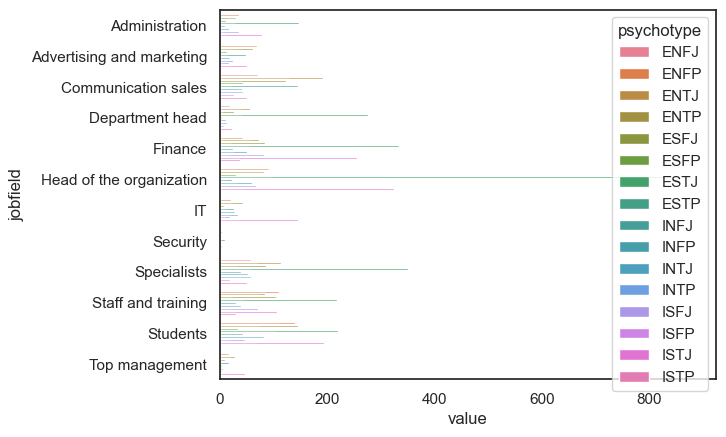

In [843]:
# Pivot data
df_pivot = contingency_table.reset_index().melt(id_vars='jobfield')

# Create bar chart
sns.barplot(x='value', y='jobfield', hue='psychotype', data=df_pivot, ci=None)

# Plot Show
plt.show()


## Content-Based Filtering Explanation with Fuzzy Logic

### Overview

This implementation focuses on building a content-based recommendation system using a scale-based algorithm augmented with fuzzy logic. The approach involves leveraging personality scales, measuring various dimensions such as extraversion vs. introversion, sensing vs. intuition, thinking vs. feeling, and judging vs. perceiving. The goal is to provide job recommendations that align with Job preferences based on their psychometric profiles, incorporating fuzzy logic for enhanced flexibility in handling imprecise preferences.

### Process Explanation

#### 1. Normalization of Scales with Fuzzy Logic
   - The initial step involves normalizing each personality scale using Min-Max scaling, incorporating fuzzy logic to handle the inherent imprecision in psychometric measurements. This ensures a consistent range of values for each dimension, facilitating uniform access and calculations in subsequent steps.

#### 2. Weight Calculation for Each Scale
   - We calculate weights for each scale based on the number of jobs in the same field, introducing fuzzy logic to accommodate uncertainties in job preferences. This step emphasizes preferences that align with specific work environments, providing a nuanced weighting system that considers imprecise data.

#### 3. Job Profile Formation with Fuzzy Logic
   - Job profiles are formed by summing weighted scales for each personality type, integrating fuzzy logic to capture the vagueness in psychological tendencies. This creates a numerical representation of a Job's psychological profile in the context of jobs, accounting for imprecise preferences.

#### 4. Integration of MBTI and Job Profiles
   - Job profiles, enriched with fuzzy logic-enhanced scales, are seamlessly integrated into the main dataframe by merging them with job profiles. This integration ensures a holistic representation of Job and job preferences, considering uncertainties in both.

#### 5. Unique Job Profile Creation with Fuzzy Logic
   - Unique Job profiles are generated based on personality types, incorporating fuzzy logic to handle imprecision in the profiling process. Each profile includes fuzzy weighted values for each scale, forming the foundation for personalized recommendations that account for vagueness in Job preferences.

### Rationale

This approach was chosen because it not only utilizes detailed information about Job preferences, measured in terms of personality scales but also integrates fuzzy logic to enhance the system's flexibility in handling imprecise or vague data. The combination of Min-Max scaling and fuzzy logic ensures consistency and adaptability in representing and interpreting psychometric data. By incorporating fuzzy logic into the Job and job profile integration process, the system can deliver more accurate and tailored recommendations, accommodating the inherent uncertainties in Job preferences and psychometric measurements.


In [844]:
class CBFRecommender:
    def __init__(self, df):
        self.df = df
        self.job_counts = df.groupby('jobfield')['psychotype'].value_counts()
        self.scaler = MinMaxScaler()

    def get_fuzzy_scale(self, scale):
        return self.scaler.fit_transform(self.df[[scale]])

    def get_weighted_scale(self, scale):
        weighted_scale = self.df['normalized_'+scale] * self.df.set_index(['jobfield', 'psychotype']).index.map(self.job_counts)
        return self.scaler.fit_transform(weighted_scale.values.reshape(-1, 1))

    def build_job_profile(self):
        job_profile = self.df.groupby('psychotype')[['weighted_scale_e', 'weighted_scale_i', 'weighted_scale_s', 'weighted_scale_n', 'weighted_scale_t', 'weighted_scale_f', 'weighted_scale_j', 'weighted_scale_p']].sum()
        scaler = MinMaxScaler()
        normalized_job_profile = pd.DataFrame(scaler.fit_transform(job_profile), columns=job_profile.columns, index=job_profile.index)
        return normalized_job_profile
    
    def recommend(self, input_psychotype):
        # Get unique user profile
        unique_job_profile = self.get_unique_job_profile(self.build_job_profile())
        
        # Calculate recommendation scores for new jobs
        for psychotype in self.df['psychotype'].unique():
            self.df.loc[self.df['psychotype'] == psychotype, 'cbf_score'] = sum(
                self.df.loc[self.df['psychotype'] == psychotype, 'normalized_'+scale] * unique_job_profile[input_psychotype]['job_profile_'+scale]
                for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']
            )
        
        # Sort by recommendation score and select only 'jobfield' and 'cbf_score'
        recommendations = self.df.sort_values(by='cbf_score', ascending=False)[['jobtitle','jobfield', 'cbf_score']]
        
        return recommendations

    def get_unique_job_profile(self, normalized_job_profile):
        return {
            psychotype:{
                'job_profile_'+scale: normalized_job_profile.loc[psychotype]['weighted_'+scale]
                for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']
            } for psychotype in normalized_job_profile.index.unique()
        }

    def process(self):
        # Normalize each scale
        for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']:
            self.df['normalized_'+scale] = self.get_fuzzy_scale(scale)

        # Calculate weights for each scale based on the number of jobs in the same field
        for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']:
            self.df['weighted_'+scale] = self.get_weighted_scale(scale)

        # Form user profile by summing scales in the weight matrix for each movie
        normalized_job_profile = self.build_job_profile()

        # Add job profile to the dataframe
        self.df = self.df.join(normalized_job_profile, on='psychotype', rsuffix='_job')

        # Get unique user profile
        unique_job_profile = self.get_unique_job_profile(normalized_job_profile)

        return self.df, unique_job_profile

### Apply Content Based Recommender

In this section, a simulation is performed to test the recommendation system for three new dummy jobs. The objective is to assess the system's ability to generate relevant job recommendations based on a user profile with a specific psychotype, in this case, 'ISTJ.'


In [845]:
# # Initialize the CBFRecommender
cbfrecommender = CBFRecommender(df)

# # Process the dataframe and get unique user profile
df, unique_job_profile = cbfrecommender.process()

# # Calculate similarity scores and get top 5 recommendations
recommendations = cbfrecommender.recommend('ENTP')
top_5_recommendations = recommendations.head(5).reset_index(drop=True)
top_5_recommendations

,jobtitle,jobfield,cbf_score
0,Head (marketing advertising),Advertising and marketing,0.234377
1,System administrator,IT,0.234214
2,Student,Students,0.233860
3,Journalist,Specialists,0.231990
4,Brand manager,Advertising and marketing,0.231757


### Export CBF Result Data

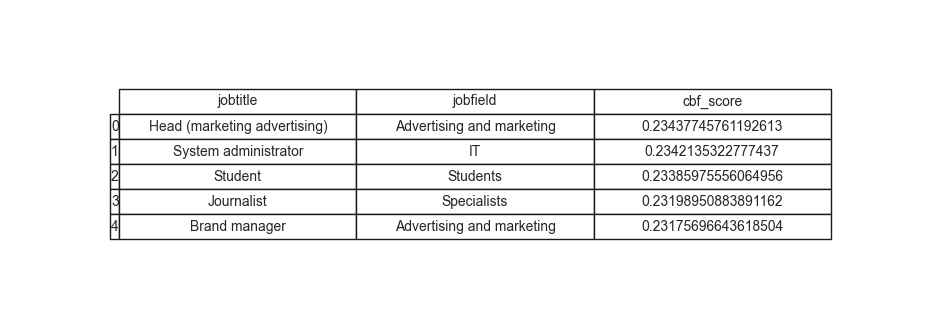

In [846]:
# Create a figure with matplotlib
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)  # no visible frame
tabla = table(ax, top_5_recommendations, loc='center', cellLoc = 'center', colWidths=[0.17]*len(df.columns))  
tabla.auto_set_font_size(False) 
tabla.set_fontsize(10) 
tabla.scale(1.5, 1.5) 

# Save the table as a png image
plt.savefig('results/cbf_recommendations.png')

# Plot Show
plt.show()


#### 3 Dummy Jobs Recommendation Score Based on scale

Three new dummy jobs are created with distinct titles, fields, and assigned psychotype 'ISTJ.' Each job is associated with random values for personality scales ('scale_e,' 'scale_i,' 'scale_s,' 'scale_n,' 'scale_t,' 'scale_f,' 'scale_j,' and 'scale_p') to simulate diverse job characteristics and requirements.


In [847]:
# Create 3 new dummy jobs
new_jobs = pd.DataFrame({
    'jobtitle': ['Job Title 1', 'Job Title 2', 'Job Title 3'],
    'jobfield': ['New Job Field 1', 'New Job Field 2', 'New Job Field 3'],
    'psychotype': ['ISFJ', 'ISFJ', 'ISFJ'],
    'scale_e': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_i': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_s': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_n': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_t': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_f': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_j': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_p': [np.random.rand(), np.random.rand(), np.random.rand()]
})

# Calculate recommendation scores for new jobs
for psychotype in new_jobs['psychotype'].unique():
    new_jobs.loc[new_jobs['psychotype'] == psychotype, 'recommendation_score'] = sum(
        new_jobs.loc[new_jobs['psychotype'] == psychotype, scale] * unique_job_profile[psychotype]['job_profile_'+scale]
        for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']
    )

new_jobs.sort_values(by='recommendation_score', ascending=False, inplace=True)

new_jobs

,jobtitle,jobfield,psychotype,scale_e,scale_i,scale_s,scale_n,scale_t,scale_f,scale_j,scale_p,recommendation_score
2,Job Title 3,New Job Field 3,ISFJ,0.028446,0.965042,0.696332,0.571175,0.002535,0.941816,0.570164,0.334121,0.092751
0,Job Title 1,New Job Field 1,ISFJ,0.684937,0.565258,0.968105,0.840713,0.049169,0.504684,0.220860,0.782199,0.083613
1,Job Title 2,New Job Field 2,ISFJ,0.317796,0.193873,0.600238,0.681573,0.753710,0.340020,0.643648,0.465725,0.063108


### Export CBF New Job Recommendation

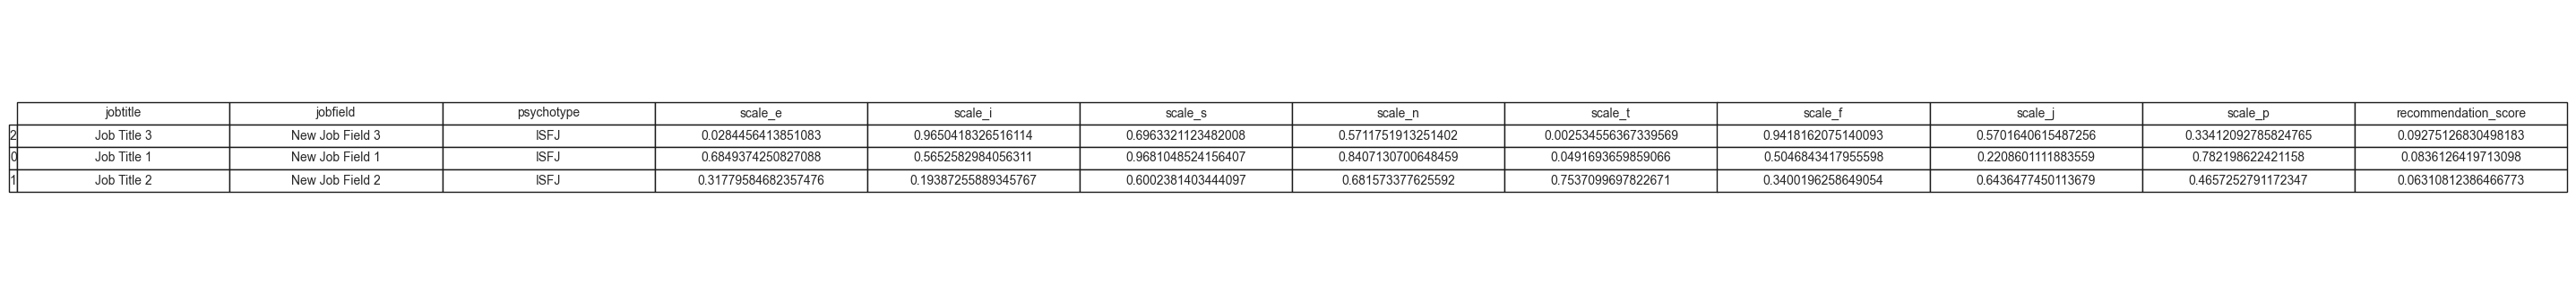

In [848]:
# Create a figure with matplotlib
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)  # no visible frame

# Create a table with the top 5 recommendations
tabla = table(ax, new_jobs.head(5), loc='center', cellLoc = 'center', colWidths=[0.17]*len(new_jobs.columns))  
tabla.auto_set_font_size(False) 
tabla.set_fontsize(10) 
tabla.scale(1.5, 1.5) 

# Save the table as a png image
plt.savefig('results/new_jobs_recommendations.png')

# Plot Show
plt.show()


## Collaborative Recommender

### Overview

Our Collaborative Recommender employs memory-based collaborative filtering, specifically the user-based approach, to provide personalized job recommendations based on MBTI profiles.

### Implementation Strategy

The primary implementation strategy for our collaborative recommender is:

- **Memory-based:**
  - **User-based:** Computes similarities between users based on their historical interactions with job fields. Users with similar preferences receive recommendations for analogous jobs.

- **Model-based:**
  - **Cosine Similarity for Distance Calculation:**
    - In the process of recommending jobs based on MBTI profiles, we leverage the cosine similarity metric for measuring the distance between data points. The cosine similarity computes the cosine of the angle between two vectors, producing values ranging from -1 to 1. Specifically:
      - If two vectors have the same direction, the cosine similarity is 1.
      - Conversely, if two vectors have opposite directions, the cosine similarity is -1.
    - This metric helps us quantify the similarity between MBTI profiles, allowing us to recommend jobs based on the alignment of user preferences.
  - **Brute-Force Algorithm for Nearest Neighbor Search:**
    - To determine the nearest neighbors in our model-based collaborative filtering, we employ a brute-force algorithm. This method involves calculating the distance between each pair of data points. In our case, it entails measuring the cosine similarity between MBTI profiles.
    - While brute-force algorithms may not be the most computationally efficient, they provide a straightforward and reliable approach to finding nearest neighbors in the context of our recommendation system. The algorithm exhaustively evaluates all possible pairs, ensuring a comprehensive analysis of user similarities.

### Algorithm Feature

In our implementation, the algorithm focuses on user-based collaborative filtering, maximizing the user experience by understanding similarities between users. The system identifies users with comparable preferences and suggests job fields aligning with their collective choices.


In [849]:
class CFRecommender:
    def __init__(self, df):
        self.df = df
        self.job_counts = df.groupby(['psychotype', 'jobfield']).size().reset_index(name='counts')
        scaler = MinMaxScaler()
        self.job_counts['normalized_counts'] = scaler.fit_transform(self.job_counts['counts'].values.reshape(-1,1)).flatten()
        self.matrix = self.job_counts.pivot(index='psychotype', columns='jobfield', values='normalized_counts').fillna(0)
        self.model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model_knn.fit(self.matrix)

    def recommend(self, input_psychotype, n_neighbors=16):
        distances, indices = self.model_knn.kneighbors(self.matrix.loc[input_psychotype].values.reshape(1, -1), n_neighbors=n_neighbors)
        weighted_job_counts = self.matrix.copy()
        for i in range(len(distances.flatten())):
            weighted_job_counts.iloc[i] *= distances.flatten()[i]
        recommendation_values = weighted_job_counts.sum() / distances.sum()
        recommendations = recommendation_values.sort_values(ascending=False)
        recommendations_df = pd.DataFrame(recommendations).reset_index()
        recommendations_df.columns = ['jobfield', 'cf_score']
        
        # Add jobtitle to the recommendations
        recommendations_df = recommendations_df.merge(self.df[['jobfield', 'jobtitle']].drop_duplicates(), on='jobfield', how='left')
        
        # Drop duplicates based on jobfield
        recommendations_df = recommendations_df.drop_duplicates(subset='jobfield', keep='first')
        
        # Reorder the columns
        recommendations_df = recommendations_df[['jobfield', 'jobtitle', 'cf_score']]
        
        return recommendations_df

## Apply Collaborative Recommender

In [850]:
# Initialize the recommender
recommender = CFRecommender(df)

# Get recommendations for a specific psychotype
recommendations = recommender.recommend('ENTP')
top_5_recommendations = recommendations.head(5).reset_index(drop=True)
top_5_recommendations

d:\Tubes\Matdis\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,jobfield,jobtitle,cf_score
0,Head of the organization,Businessman,0.140649
1,Communication sales,Sales Agent (real estate insurance),0.134964
2,Specialists,Sales Agent (real estate insurance),0.109980
3,Students,Graduate student,0.101652
4,Finance,Financial analyst,0.091209


### Export CF Result Data

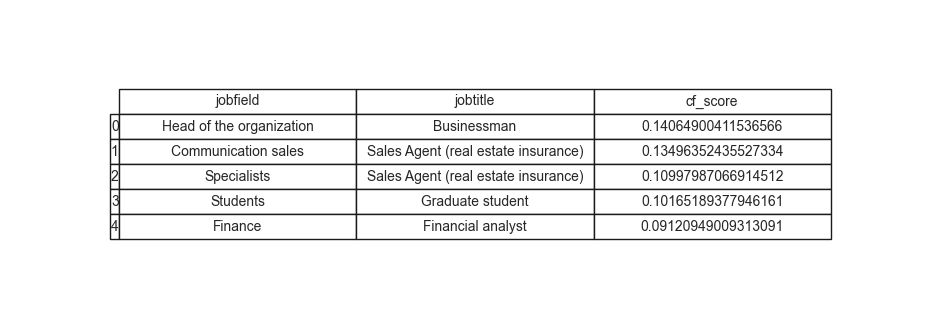

In [851]:
# Create a figure with matplotlib
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)  # no visible frame

# Create a table with the top 5 recommendations
tabla = table(ax, top_5_recommendations, loc='center', cellLoc = 'center', colWidths=[0.17]*len(top_5_recommendations.columns))  
tabla.auto_set_font_size(False) 
tabla.set_fontsize(10) 
tabla.scale(1.5, 1.5) 

# Save the table as a png image
plt.savefig('results/cf_recommendations.png')

# Plot Show
plt.show()


## Hybrid Recommender

Integrating both content-based and collaborative approaches into a hybrid methodology has demonstrated enhanced performance in numerous research studies. In our system, we construct an ensemble that calculates the weighted average of normalized recommendation scores. Given the higher recall of the content-based approach, we incorporate weighting to optimize the recommendation outcomes.


In [852]:
class HybridRecommender:
    def __init__(self, df, cf_weight=1, cbf_weight=1):
        self.df = df
        self.cf_recommender = CFRecommender(df)
        self.cbf_recommender = CBFRecommender(df)
        self.cf_weight = cf_weight
        self.cbf_weight = cbf_weight

    def recommend(self, input_psychotype, n_neighbors=16):
        # Get recommendations from both models
        cf_recommendations = self.cf_recommender.recommend(input_psychotype, n_neighbors)
        cbf_recommendations = self.cbf_recommender.recommend(input_psychotype)

        # Now you can merge the DataFrames
        combined_recommendations = pd.merge(cf_recommendations, cbf_recommendations, on='jobfield', how='outer').fillna(0)
        # Calculate the hybrid score based on the weights
        combined_recommendations['hybrid_score'] = (combined_recommendations['cf_score'] * self.cf_weight) + (combined_recommendations['cbf_score'] * self.cbf_weight)

        # Sort by the hybrid score
        
        combined_recommendations = combined_recommendations.drop_duplicates(subset='jobfield', keep="first").reset_index().sort_values(by='hybrid_score', ascending=False)

        return combined_recommendations

## Apply Hybrid Recommender System

In [853]:
# Initialize the recommender
hybrid_recommender = HybridRecommender(df)

# Get recommendations for a specific psychotype
recommendations = hybrid_recommender.recommend('ENTP')
top_5_recommendations = recommendations.head(5)
top_5_recommendations

d:\Tubes\Matdis\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,index,jobfield,jobtitle_x,cf_score,jobtitle_y,cbf_score,hybrid_score
0,0,Head of the organization,Businessman,0.140649,General director,0.226644,0.367293
1,2105,Communication sales,Sales Agent (real estate insurance),0.134964,Account Manager,0.229714,0.364678
2,4217,Specialists,Sales Agent (real estate insurance),0.109980,Journalist,0.231990,0.341969
3,5729,Students,Graduate student,0.101652,Student,0.233860,0.335512
4,7234,Finance,Financial analyst,0.091209,Head (Finance Law),0.214933,0.306142


### Export Hybrid Result Data


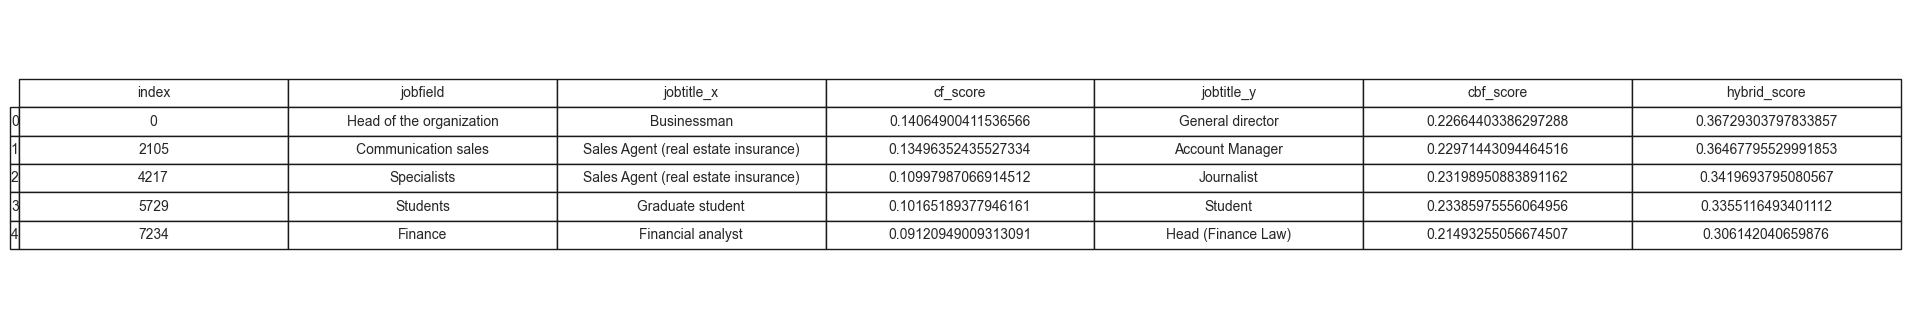

In [854]:
# Create a figure with matplotlib
fig, ax = plt.subplots(figsize=(12, 4)) 
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 
ax.set_frame_on(False)  # no visible frame

# Create a table with the top 5 recommendations
tabla = table(ax, top_5_recommendations, loc='center', cellLoc = 'center', colWidths=[0.17]*len(top_5_recommendations.columns))  
tabla.auto_set_font_size(False) 
tabla.set_fontsize(10) 
tabla.scale(1.7, 1.7) 

# Plot Show
plt.show()
